# Modelo Long Short-Term Memory (LSTM) 



En este cuaderno de Jupyter se construye el modelo LSTM usando los hiperparámetros calculados en el cuaderno `hiperparamtros_LSTM.ipynb` 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os

# Escalamiento
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# modelo SVR
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import TimeSeriesSplit

## Lectura de datasets 

In [2]:
# Nombre de las acciones
tickers = [
    'TSCO', 'AZN', 'BARC', 'BP', 'BATS', 'HLMA',
    'HSBA', 'JMAT', 'LGEN', 'MKS', 'PSON', 'REL',
    'NWG', 'SHEL', 'SGE', 'SBRY', 'SDR', 'SVT',
    'SMIN', 'SSE', 'VOD'
]

data_frames = {} # Inicializo diciconario de data frames

for ticker in tickers: 
    
    df = pd.read_csv(f'datasets_features/{ticker}.csv')  # leo el dataset
    data_frames[ticker] = df                             # guardo dataframes
    
print(data_frames.keys())

dict_keys(['TSCO', 'AZN', 'BARC', 'BP', 'BATS', 'HLMA', 'HSBA', 'JMAT', 'LGEN', 'MKS', 'PSON', 'REL', 'NWG', 'SHEL', 'SGE', 'SBRY', 'SDR', 'SVT', 'SMIN', 'SSE', 'VOD'])


In [220]:


data_frames['AZN'].drop(columns=['Date', 'Open', 'High', 'Low','Close','Volume', 'prev_close', 'target'])

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,RSI_14,Momentum_10,True_Range,ATR_14,PSAR
0,0.003986,0.014756,-0.008076,0.009427,0.000000,0.003986,0.018743,0.010667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.315538,-1.026767,2.898254,4.541970,732.729431
1,0.002650,0.003986,0.014756,-0.008076,0.000000,0.002650,0.006636,0.021392,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.903072,-0.764153,1.932922,4.355610,730.854565
2,-0.003977,0.002650,0.003986,0.014756,0.000000,-0.003977,-0.001328,0.002659,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.869166,0.156291,2.899414,4.251596,730.405334
3,-0.017415,-0.003977,0.002650,0.003986,0.000000,-0.017415,-0.021392,-0.018743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.834910,-1.703437,12.559753,4.845036,730.405334
4,0.006734,-0.017415,-0.003977,0.002650,0.000000,0.006734,-0.010681,-0.014658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.990610,-1.039250,4.830872,4.844024,728.762878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6418,-0.027029,0.019187,0.005169,0.002831,0.000000,0.010569,0.014797,0.021251,0.021639,0.014642,0.011463,-0.020777,0.000000,0.000000,0.000000,58.125765,1.275706,189.726853,108.903427,6276.899417
6419,0.003929,-0.027029,0.019187,0.005169,0.005501,-0.013699,-0.003130,0.001098,0.000000,0.021639,0.014642,-0.003790,-0.020777,0.000000,0.000000,59.364878,0.965960,58.914650,105.332800,6307.336325
6420,0.005630,0.003929,-0.027029,0.019187,0.011707,0.015482,-0.003718,0.006851,0.005501,0.000000,0.021639,-0.003933,-0.003790,-0.020777,0.000000,61.147688,2.053137,99.855320,104.941551,6325.835159
6421,-0.008772,0.005630,0.003929,-0.027029,0.001864,0.011552,0.015327,-0.003873,0.011707,0.005501,0.000000,-0.018519,-0.003933,-0.003790,-0.020777,56.961120,1.001110,129.811937,106.718007,6530.540315


## Función para 1 bloque - 1 acción 

In [3]:
def crear_secuencias(array, timesteps = 50):
    '''
    array: array en 2D
    '''
    
    rows, cols = array.shape
    X_secuencias, y_secuencias = [], [] 
    
    for i in range(rows - timesteps): 
        
        x = array[i : i + timesteps, 0:cols]
        y = array[i + timesteps, 0]  # La primera columna debe ser r1=retorno simple
    
        X_secuencias.append(x)
        y_secuencias.append(y)
        
    X_secuencias = np.array(X_secuencias)
    y_secuencias = np.array(y_secuencias).reshape(-1, 1)
    
    return X_secuencias, y_secuencias 

In [ ]:
def crear_secuencias_2(array, timesteps = 50):
    '''
    array: array en 2D
    '''
    
    rows, cols = array.shape
    X_secuencias, y_secuencias = [], [] 
    
    for i in range(rows - timesteps): 
        
        x = array[i : i + timesteps, 0:cols]
        y = array[i + timesteps, 0]  # La primera columna debe ser r1=retorno simple
    
        X_secuencias.append(x)
        y_secuencias.append(y)
        
    X_secuencias = np.array(X_secuencias)
    y_secuencias = np.array(y_secuencias).reshape(-1, 1)
    
    return X_secuencias, y_secuencias

In [131]:
def modelo_LSTM(df_bloque, model, timesteps):
    '''
    Dado un bloque de 1000 días, esta función usa el 'Long Short-Term Memory (LSTM)' para predecir. 
    Parametros:
    -----------
        df_bloque : pd.DataFrame con bloque de 1000 días. 
            Contiene los 20 features + (open, close, high, low,...)
        model : modelo a aplicar
    
    Return:
    -------
        diccionario : devuelve un diccionario con los resultados de prediciones y metricas. 
            Tiene como claves: y_pred, y_test, y_pred_s, y_test_s, y_pre_close, y_test_close, metrics
    
    '''
    
    # 1) ------------- Partición de datos ---------------- 
    
    df_features = df_bloque.drop(columns=['Date', 'Open', 'High', 'Low','Close','Volume', 'prev_close', 'target']) # todas columnas r_i
    target      = df_bloque['target']  # columna del target
    close       = df_bloque['Close']   # columna precio cierre
    
    ini_train, fin_train = 0, 749 
    ini_test, fin_test = 750, 999 
    
    X_train = df_features.iloc[ : fin_train + 1]
    X_test  = df_features.iloc[ini_test : fin_test + 1]
    y_train = target.iloc[ : fin_train + 1]
    y_test  = target.iloc[ini_test : fin_test + 1]
    y_test_close = close.iloc[ini_test : fin_test + 1]

    # 2) ----------- Estandarización ---------------------
    # Features 
    scaler_x = MinMaxScaler(feature_range=(-1,1))
    X_train_s = scaler_x.fit_transform(X_train)     
    X_test_s  = scaler_x.transform(X_test)

    # Target (al estandarizar son 2D)
    scaler_y = MinMaxScaler(feature_range=(-1,1))
    y_train_s = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel() # Necesario reshape, scaler espera 2D      
    y_test_s  = scaler_y.transform(y_test.values.reshape(-1, 1))
    
    # 2.1) --------------Crear secuencias ----------------------
    array_features = np.vstack((X_train_s, X_test_s))
    
    X_secuencias_s, y_secuencias_s = crear_secuencias(array_features, timesteps=timesteps)
    
    X_train_secuencias_s = X_secuencias_s[0: 750 - timesteps]
    X_test_secuencias_s =  X_secuencias_s[750 - timesteps: ]
    
    y_train_secuencias_s = y_secuencias_s[0: 750 - timesteps]
    y_test_secuencias_s  = y_secuencias_s[750 - timesteps: ]
    

    # 3) ---------- Entrenamiento y predicción del modelo --------------------
    
    model.fit(X_train_secuencias_s, y_train_secuencias_s)
    y_pred_s = model.predict(X_test_secuencias_s)
    y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1, 1)).ravel() 
    
    # en caso de no estandarizar
    #model.fit(X_train, y_train)
    #y_pred = model.predict(X=X_test)

    # Predicción de los precios   
    P_real_test = close.iloc[ini_test : fin_test + 1]  
    y_pred_close = np.zeros(249)
    
    for k in range(len(y_pred_close)): 
        y_pred_close[k] = P_real_test.iloc[k]*np.exp(y_pred[k])  

    
    y_test_close = close.iloc[ini_test + 1  : fin_test + 1] # Prediccion incia en P_751
    
    # 4) ---------- Cálculo de métricas ------------------
    mse   = mean_squared_error(y_true = y_test, y_pred = y_pred)     
    #mse_s = mean_squared_error(y_true = y_test_s, y_pred = y_pred_s)
    rmse   = np.sqrt(mse)
    #rmse_s = np.sqrt(mse_s)
    mae   = mean_absolute_error(y_true = y_test, y_pred = y_pred)
    #mae_s = mean_absolute_error(y_true = y_test_s, y_pred = y_pred_s)
    r2   = r2_score(y_true = y_test, y_pred = y_pred)
    #r2_s = r2_score(y_true = y_test_s, y_pred = y_pred_s)
    
    # prints
    # print('array_features', array_features.shape)
    # print('X_secuencias_s', X_secuencias_s.shape)
    # print('y_secuencias_s', y_secuencias_s.shape)
    # print('X_train_secuencias_s:', X_train_secuencias_s.shape)
    # print('X_test_secuencias_s: ', X_test_secuencias_s.shape)
    # print('y_train_secuencias_s:', y_train_secuencias_s.shape)
    # print('y_test_secuencias_s: ', y_test_secuencias_s.shape)
    # print()
    # print('y_pred:', y_pred.shape)
    # print('y_test:', y_test.shape)
    # print()
    # print('P_real_test: ', P_real_test.shape)
    # print('y_pred_close:', y_pred_close.shape)
    # print('y_test_close', y_test_close.shape)
    
    #print()
    #display(df_features.iloc[745:755])
    #display(pd.DataFrame(array_features[745:755]))
    #display('Ultima seq del X_train_secuecnias_s:', pd.DataFrame(X_train_secuencias_s[-1]))
    #display('Ultima seq del y_train_secuecnias_s:', pd.DataFrame(y_train_secuencias_s[-1]))
    #print()
    #display('Primera seq del X_test_secuecnias_s:', pd.DataFrame(X_test_secuencias_s[0]))
    #display('Primera seq del y_test_secuecnias_s:', pd.DataFrame(y_test_secuencias_s[0]))
    #display('Segunda seq del X_test_secuecnias_s:', pd.DataFrame(X_test_secuencias_s[1]))
    #display('Segunda seq del y_test_secuecnias_s:', pd.DataFrame(y_test_secuencias_s[1]))
    

    
    
    # --------------- Returns ---------------------
    diccionario = {}
    diccionario['y_pred'] = y_pred
    diccionario['y_test'] = y_test.values
    #diccionario['y_pred_s'] = y_pred_s
    #diccionario['y_test_s'] = y_test_s
    diccionario['metrics'] = {'mse':mse, 'rmse':rmse, 'mae':mae, 'r2':r2}
    #diccionario['metrics_s'] = {'mse_s':mse_s, 'rmse_s':rmse_s, 'mae_s':mae_s, 'r2_s':r2_s}
    
    # para los gráficos del Precio cierre 
    diccionario['y_pred_close'] = y_pred_close
    diccionario['y_test_close'] = y_test_close 
    
    
    return diccionario 

In [132]:
modelo_LSTM(df[0:1000], model = model2, timesteps=5)['metrics']

8/8 [==============================] - 0s 2ms/step


{'mse': 0.00038930125488744686,
 'rmse': 0.01973071855983575,
 'mae': 0.015678247687030397,
 'r2': -1.025563058896514}

## Construcción del modelo 

In [242]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers

timesteps = 70

model2 = tf.keras.Sequential()


# First layer
model2.add(keras.layers.LSTM(64, return_sequences=False, input_shape=(timesteps,20) # 80, 64
                            #,kernel_regularizer=regularizers.l2(1e-6), 
                            #recurrent_regularizer=regularizers.l2(1e-6)
                           ) 
          
         )

# Second layer 
#model.add(keras.layers.LSTM(64, return_sequences=False))

# 3rd layer 
model2.add(keras.layers.Dense(56, activation='relu'))    #64, relu. 56

# 4th layer (Dropout)
model2.add(keras.layers.Dropout(0.3)) #0.1

# Final output layer 
model2.add(keras.layers.Dense(1))

model2.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 64)                21760     
                                                                 
 dense_60 (Dense)            (None, 56)                3640      
                                                                 
 dropout_29 (Dropout)        (None, 56)                0         
                                                                 
 dense_61 (Dense)            (None, 1)                 57        
                                                                 
Total params: 25457 (99.44 KB)
Trainable params: 25457 (99.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Ejemplo:**

In [243]:
# Elijo un data set
df = data_frames['AZN']

In [244]:
# Compilar
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model2.compile(optimizer=optimizer, loss="mse")

# display(len(modelo_LSTM(df[0:1000], model = model2, timesteps=50)['y_pred_close']))



In [245]:
modelo_LSTM(df[0:1000], model = model2, timesteps=70)['metrics']

8/8 [==============================] - 2s 144ms/step


{'mse': 0.00020228093736720466,
 'rmse': 0.014222550311642587,
 'mae': 0.01112699259352524,
 'r2': -0.052482593122977095}

In [33]:
modelo_LSTM(df[0:1000], model = model2, timesteps=50)['metrics']

8/8 [==============================] - 0s 17ms/step


{'mse': 0.00021001285612473679,
 'rmse': 0.01449182031784609,
 'mae': 0.011420297818402904,
 'r2': -0.09271233503370913}

In [174]:
timesteps_list = np.arange(30,200, 2)
best_mse = 99999
for t in timesteps_list: 
    mse = modelo_LSTM(df[0:1000], model = model2, timesteps=int(t))['metrics']['mse']
    
    if mse < best_mse: 
        best_mse = mse
        print(f'mse:{best_mse}, timesteps={int(t)}')

8/8 [==============================] - 0s 10ms/step
mse:0.00023053935474579918, timesteps=30
8/8 [==============================] - 0s 14ms/step
mse:0.00021562188838674905, timesteps=32
8/8 [==============================] - 0s 13ms/step
mse:0.0002069231224064455, timesteps=34
8/8 [==============================] - 0s 10ms/step
mse:0.00020335397418680135, timesteps=36
8/8 [==============================] - 0s 10ms/step
mse:0.0002003922406435959, timesteps=38
8/8 [==============================] - 0s 13ms/step
mse:0.00019854337107479952, timesteps=40
8/8 [==============================] - 0s 13ms/step
mse:0.00019719080720792314, timesteps=44
8/8 [==============================] - 0s 14ms/step
mse:0.00019671464160105667, timesteps=46
8/8 [==============================] - 0s 17ms/step
mse:0.00019658575032658343, timesteps=58
8/8 [==============================] - 0s 17ms/step
mse:0.00019585113086522464, timesteps=62
8/8 [==============================] - 0s 19ms/step
mse:0.00019566114723

## Modelo sobre todos los datasets y todos los bloques 

Ahora para cada uno de los bloques y cada una de las acciones, calculamos las correspondientes predicciones y métricas usando la función anteriormente definida. 

In [246]:
# Alamacenaré mis resultados en un diccionario
resultados = {}

for ticker, df in data_frames.items(): 
    print(f'Calculando {ticker}.')
    
    resultados[ticker] = {}
    #dicc_resultados[ticker]['metricas'] = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'R2']

    for n_bloque in range(20): 
        
        # inicializo paara guardar resultados
        bloque_name = f'Bloque_{n_bloque}'
        resultados[ticker][bloque_name] = {'predicciones': pd.DataFrame(columns=['y_test', 'y_pred', 'y_test_close', 'y_pred_close']),
                                           'metricas': pd.DataFrame(columns=['mse', 'rmse', 'mae', 'r2'])
                                          }
        ini_bloque = 250*n_bloque
        fin_bloque = 250*n_bloque + 999
        df_bloque = df.iloc[ini_bloque : fin_bloque + 1]
        #print(f'Bloque {n_bloque}: ini_bloque ({ini_bloque}:{fin_bloque}) - len={df_bloque.shape}')
        
        # CALCULO UN SOLO BLOQUE
        dicc_bloque = modelo_LSTM(df_bloque, model=model2, timesteps=70)
        
        mse  = dicc_bloque['metrics']['mse']
        rmse = dicc_bloque['metrics']['rmse']
        mae  = dicc_bloque['metrics']['mae']
        r2   = dicc_bloque['metrics']['r2']
        
        # Almaceno predicciones de cada bloque
        resultados[ticker][bloque_name]['predicciones']['y_test'] = dicc_bloque['y_test']
        resultados[ticker][bloque_name]['predicciones']['y_pred'] = dicc_bloque['y_pred']
        resultados[ticker][bloque_name]['predicciones'].loc[1:, 'y_test_close'] = dicc_bloque['y_test_close']
        resultados[ticker][bloque_name]['predicciones'].loc[1:, 'y_pred_close'] = dicc_bloque['y_pred_close']
        resultados[ticker][bloque_name]['metricas'].loc[bloque_name]     = [mse, rmse, mae, r2]

Calculando TSCO.
8/8 [==============================] - 0s 32ms/step
Calculando AZN.
8/8 [==============================] - 0s 29ms/step
Calculando BARC.
8/8 [==============================] - 0s 29ms/step
Calculando BP.
8/8 [==============================] - 0s 30ms/step
Calculando BATS.
8/8 [==============================] - 0s 32ms/step
Calculando HLMA.
8/8 [==============================] - 0s 29ms/step
Calculando HSBA.
8/8 [==============================] - 0s 31ms/step
Calculando JMAT.
8/8 [==============================] - 0s 32ms/step
Calculando LGEN.
8/8 [==============================] - 0s 36ms/step
Calculando MKS.
8/8 [==============================] - 0s 34ms/step
Calculando PSON.
8/8 [==============================] - 0s 31ms/step
Calculando REL.
8/8 [==============================] - 0s 40ms/step
Calculando NWG.
8/8 [==============================] - 0s 33ms/step
Calculando SHEL.
8/8 [==============================] - 0s 33ms/step
Calculando SGE.
8/8 [===================

In [240]:
# Ejemplo: acción AZN - Bloque 0
display(resultados['AZN']['Bloque_0'].keys())
display(resultados['AZN']['Bloque_0']['predicciones'])
display(resultados['AZN']['Bloque_0']['metricas'])

dict_keys(['predicciones', 'metricas'])

,y_test,y_pred,y_test_close,y_pred_close
0,-0.009465,0.011780,NaN,NaN
1,-0.015508,0.011523,NaN,1764.59435
2,-0.012863,0.011401,NaN,1747.52169
3,-0.009545,0.011290,NaN,1720.420809
4,0.014713,0.010527,NaN,1698.244025
...,...,...,...,...
245,-0.026434,0.007753,NaN,2167.076869
246,0.004691,0.008315,NaN,2128.517782
247,0.012546,0.010706,NaN,2074.154812
248,0.005530,0.011170,NaN,2088.896809


,mse,rmse,mae,r2
Bloque_0,0.000299,0.017279,0.013886,-0.553484


En la tabla de predicciones vemos que las predicciones de los precios de cierre tienen valores Nan en la primera fila. Esto es coherente con lo que hemos planteado: hemos dicho anteriormente que los precios de cierre predichos son 249 -> [P_751, P_752, ...., P_999]. 
Mientras que los log-retornos predichos (el target) son 250. 

### Guardo dataframe de métricas 

In [247]:
# Creo mi data frame de métricas (filas = acciones, columnas = metrica)

tickers = list(resultados.keys())
bloques = list(resultados['AZN'].keys())

# inicializo data frame
df_intermedio = pd.DataFrame(columns=['mse','rmse','mae','r2'])
df_metricas = pd.DataFrame(columns=['MSE','RMSE','MAE','R2'])


for ticker in tickers:
    for bloque in bloques: 
        # Junto las metricas de cada bloque (misma ticker/accion)
        df_intermedio.loc[bloque] = resultados[ticker][bloque]['metricas'].loc[bloque].values

    # Calculo media sobre todos los bloques 
    medias = df_intermedio.mean()
    
    # Almaceno los resultados en un nuevo data frame
    df_metricas.loc[ticker] = medias.values

    
    
# Almaceno data frame en fichero externo 
carpeta = os.path.join(os.getcwd(), 'resultados_metricas')
os.makedirs(carpeta, exist_ok=True) # Crear la carpeta si no existe
ruta_archivo = os.path.join(carpeta, f'metricas_modelo_LSTM_2.csv')
df_metricas.to_csv(ruta_archivo, index=True) # Se guarda el índice (el nombre las de acciones)
    
display(df_metricas)

,MSE,RMSE,MAE,R2
TSCO,0.000308,0.016792,0.012490,-0.020461
AZN,0.000296,0.016610,0.012269,-0.039100
BARC,0.001149,0.028739,0.022098,-0.383747
BP,0.000316,0.016983,0.012707,-0.036206
BATS,0.000303,0.015903,0.012053,-0.043179
HLMA,0.000368,0.017923,0.012878,-0.179603
HSBA,0.000360,0.017097,0.012733,-0.031092
JMAT,0.000425,0.019581,0.014327,-0.024181
LGEN,0.000683,0.023385,0.016958,-0.027131
MKS,0.000458,0.020234,0.014806,-0.103312


### Guardo dataframe de predicciones

In [248]:
# Almaceno los dataframes de las predicciones en un fichero externo 

tickers = list(resultados.keys())
bloques = list(resultados['AZN'].keys())

for ticker in tickers:
    for bloque in bloques: 
        df_predicciones = resultados[ticker][bloque]['predicciones']
        
        # Almaceno data frame en fichero externo 
        carpeta = os.path.join(os.getcwd(), 'resultados_predicciones', 'modelo_LSTM_2')
        os.makedirs(carpeta, exist_ok=True) # Crear la carpeta si no existe
        ruta_archivo = os.path.join(carpeta, f'predicciones_{ticker}_{bloque}.csv')
        df_predicciones.to_csv(ruta_archivo, index=False) # No se guarda el índice en predicciones


## Gráfica de un 1 bloque - 1 acción

In [231]:
# Elijo acción y bloque 
ticker_name = 'AZN'
bloque_name = 'Bloque_0'   

y_real = resultados[ticker_name][bloque_name]['predicciones']['y_test']
y_pred = resultados[ticker_name][bloque_name]['predicciones']['y_pred']
    
y_real_close = resultados[ticker_name][bloque_name]['predicciones'].loc[1:, 'y_test_close']
y_pred_close = resultados[ticker_name][bloque_name]['predicciones'].loc[1:, 'y_pred_close']

print(len(y_real))
print(len(y_real_close))

250
249


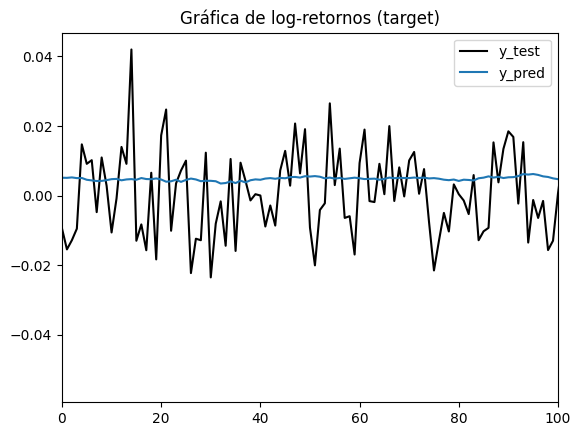

In [232]:
# Gráfica de log-retornos (target)

fig, ax = plt.subplots()
ax.plot(y_real, color='black', label='y_test')
ax.plot(y_pred, color='C0', label = 'y_pred')

# Cambio rango para ver mejor
plt.xlim([0,100])

plt.legend()
plt.title('Gráfica de log-retornos (target)')
plt.show()

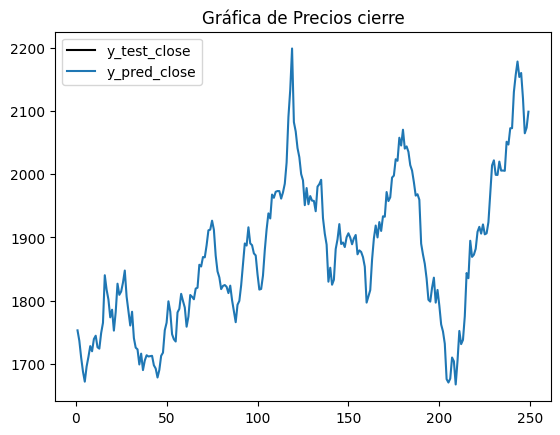

In [233]:
# Gráfica de precios cierre

fig, ax = plt.subplots()
ax.plot(y_real_close, color='black', label='y_test_close')
ax.plot(y_pred_close, color='C0', label = 'y_pred_close')

# Cambio rango para ver mejor
#plt.xlim([100,250])

plt.legend()
plt.title('Gráfica de Precios cierre')
plt.show()

In [234]:
os.getcwd()

'C:\\Users\\Usuario\\Desktop\\TFM\\Codigos python'